In [4]:
import numpy as np
import pandas as pd
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')
import re

In [2]:
train_df = pd.read_csv('train_sessions.csv',
                       index_col='session_id', parse_dates=['time1'])
test_df = pd.read_csv('test_sessions.csv',
                      index_col='session_id', parse_dates=['time1'])

train_df.sort_values('time1', inplace=True)

y_train = train_df.target

train_df.drop('target', axis = 1, inplace=True)

In [3]:
with open('site_dic.pkl', 'rb') as f:
        site2id = pickle.load(f)
        
id2site = {v:k for (k, v) in site2id.items()}

id2site[0] = 'unknown'

In [5]:
sites = ['site%s' % i for i in range(1, 11)]

train_df[sites] = train_df[sites].fillna(0).apply(lambda x: x.map(id2site))
test_df[sites] = test_df[sites].fillna(0).apply(lambda x: x.map(id2site))

train_df[sites] = train_df[sites].applymap(lambda site: re.sub("^\S*?\.*?www\S*?\.", '', site)) 
test_df[sites] = test_df[sites].applymap(lambda site: re.sub("^\S*?\.*?www\S*?\.", '', site)) 

train_sessions = train_df[sites].apply(lambda row:' '.join([i for i in row]), axis=1).tolist()
test_sessions = test_df[sites].apply(lambda row:' '.join([i for i in row]), axis=1).tolist()

idf_vec = TfidfVectorizer(ngram_range=(1,5), max_features=50000, tokenizer = lambda s: s.split())
train_tfidf = idf_vec.fit_transform(train_sessions)
test_tfidf = idf_vec.transform(test_sessions)

In [6]:
idx_splite = train_df.shape[0]

time_splite = TimeSeriesSplit(n_splits=10)

logit = LogisticRegression(C=1, solver='liblinear', random_state=17)

cross = cross_val_score(logit, train_tfidf, y_train, cv = time_splite, scoring='roc_auc', n_jobs=4)

res = {}
res['n_1'] = {'scores' : cross, 'mean' : cross.mean(), 'sd' : cross.std()}

In [7]:
# Что бы посмотреть значимость

# logit.fit(train_tfidf, y_train)

# eli5.show_weights(estimator=logit, feature_names = idf_vec.get_feature_names(), top = 100, include_styles = False)

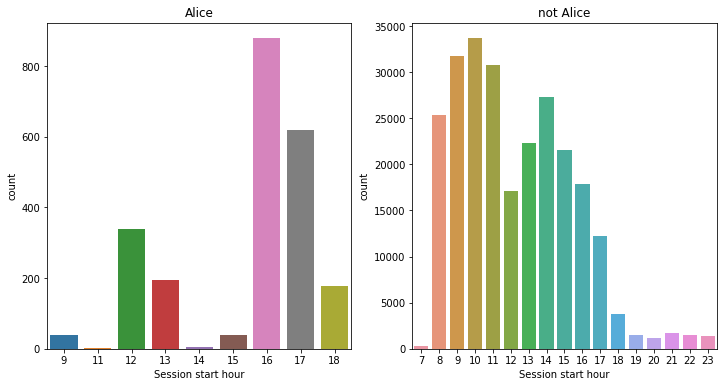

In [8]:
import seaborn as sns
plt.subplots(1, 2, figsize = (12, 6)) 

plt.subplot(1, 2, 1)
sns.countplot(pd.to_datetime(train_df.time1).dt.hour[y_train == 1])
plt.title("Alice")
plt.xlabel('Session start hour');

plt.subplot(1, 2, 2)
sns.countplot(pd.to_datetime(train_df.time1).dt.hour[y_train == 0])
plt.title("not Alice")
plt.xlabel('Session start hour');

In [9]:
def compare(new_cross, res_num):
    tmp = pd.DataFrame({res_num : res[res_num]['scores'], 
                  'new' : new_cross, 
                  'compare' : res[res_num]['scores'] < new_cross})
    print('сравнение батчей \n', tmp)
    print('\nСредние:\n', 'Новое:', new_cross.mean().round(5), '\tСтарое: ', res[res_num]['scores'].mean().round(5))
    print('\nSD:\n', 'Новое:', new_cross.std().round(5), '\tСтарое: ', res[res_num]['scores'].std().round(5))

full_df = pd.concat([train_df, test_df]).reset_index(drop = True)
full_df[['time' + str(x) for x in range(1, 11)]] = full_df[['time' + str(x) for x in range(1, 11)]].apply(pd.to_datetime)
full_df[sites] = full_df[sites].fillna(0)

time_features = pd.DataFrame(index=full_df.index)
time_features['hour'] = full_df.time1.dt.hour
time_features['morning'] = ((time_features.hour >= 7) & (time_features.hour <= 11)).astype('int')
time_features['day'] = ((time_features.hour >= 12) & (time_features.hour <= 18)).astype('int')
time_features['evening'] = ((time_features.hour >= 19) & (time_features.hour <= 23)).astype('int')
time_features['night'] = ((time_features.hour >= 0) & (time_features.hour <= 6)).astype('int')

time_features = pd.concat([time_features, pd.get_dummies(time_features.hour, prefix = 'hour')], axis = 1)

time_features = time_features[['morning', 'day', 'evening', 'hour_8', 'hour_10', 'hour_14', 'hour_23']]

cross = cross_val_score(logit, hstack([train_tfidf, time_features.values[:idx_splite]]), y_train, cv = time_splite, scoring='roc_auc', n_jobs=4)
compare(cross, 'n_1')

res['n_2'] = {'scores' : cross, 'mean' : cross.mean(), 'sd' : cross.std()}

сравнение батчей 
         n_1       new  compare
0  0.826747  0.888057     True
1  0.659157  0.848112     True
2  0.862716  0.941546     True
3  0.932639  0.944720     True
4  0.845871  0.935924     True
5  0.889533  0.959599     True
6  0.888457  0.946027     True
7  0.881465  0.947907     True
8  0.920386  0.961107     True
9  0.925794  0.961895     True

Средние:
 Новое: 0.93349 	Старое:  0.86328

SD:
 Новое: 0.03488 	Старое:  0.07546


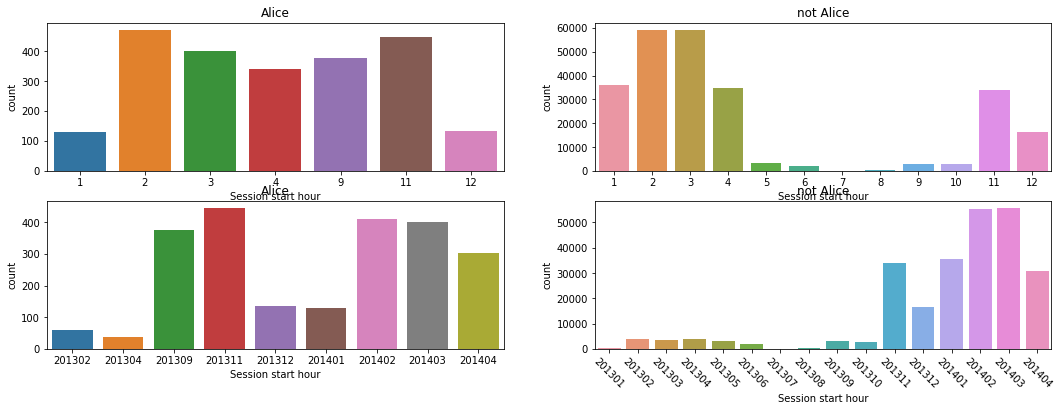

In [10]:
plt.subplots(1, 2, figsize = (18, 6)) 

plt.subplot(2, 2, 1)
sns.countplot(pd.to_datetime(train_df.time1).dt.month[y_train == 1])
plt.title("Alice")
plt.xlabel('Session start hour');

plt.subplot(2, 2, 2)
sns.countplot(pd.to_datetime(train_df.time1).dt.month[y_train == 0])
plt.title("not Alice")
plt.xlabel('Session start hour');

plt.subplot(2, 2, 3)
sns.countplot((pd.to_datetime(train_df.time1).dt.year * 100 + pd.to_datetime(train_df.time1).dt.month)[y_train == 1])
plt.title("Alice")
plt.xlabel('Session start hour');

plt.subplot(2, 2, 4)
sns.countplot((pd.to_datetime(train_df.time1).dt.year * 100 + pd.to_datetime(train_df.time1).dt.month)[y_train == 0])
plt.title("not Alice")
plt.xticks(rotation = -45)
plt.xlabel('Session start hour');

In [11]:
stnd = StandardScaler()

time_features['month'] = full_df.time1.dt.month
time_features['year'] = stnd.fit_transform(full_df.time1.dt.year.astype('float64').values.reshape(-1, 1))
time_features['yyyymm'] = time_features.year * 100 + time_features.month
time_features['yyyymm'] = stnd.fit_transform(time_features.yyyymm.values.reshape(-1, 1))

time_features = time_features.drop(['month', 'year'], axis = 1)

cross = cross_val_score(logit, hstack([train_tfidf, 
                                       time_features.values[:idx_splite, :]]), 
                        y_train, cv = time_splite, scoring='roc_auc', n_jobs=4)

compare(cross, 'n_2')
res['n_3'] = {'scores' : cross, 'mean' : cross.mean(), 'sd' : cross.std(), 'comment' : 'добавил yyyymm'}

сравнение батчей 
         n_2       new  compare
0  0.888057  0.890139     True
1  0.848112  0.850524     True
2  0.941546  0.962345     True
3  0.944720  0.945684     True
4  0.935924  0.936357     True
5  0.959599  0.959617     True
6  0.946027  0.945409    False
7  0.947907  0.947709    False
8  0.961107  0.960678    False
9  0.961895  0.961918     True

Средние:
 Новое: 0.93604 	Старое:  0.93349

SD:
 Новое: 0.03502 	Старое:  0.03488


In [12]:
# Добавление yyyymm подняло скор на паблике до 0.954

In [13]:
# Из месяцов выстрелило только yyyymm, потому что явно видкн тренд к увеличению фрода
times = ['time' + str(x) for x in range(1, 11)]

time_features['max'] = full_df[times].max(axis = 1)
time_features['min'] = full_df[times].min(axis = 1)
time_features['seconds'] = (time_features['max'] - time_features['min']).dt.seconds
time_features['seconds'] = time_features.seconds / time_features.seconds.max()
time_features['counts'] = full_df[sites].apply(lambda x: np.sum(x != 0), axis = 1)
time_features['counts'] = time_features['counts'] / time_features['counts'].max()

time_features = time_features.drop(['min', 'max'], axis = 1)

cross = cross_val_score(logit, hstack([train_tfidf, 
                                       time_features.values[:idx_splite, :]]), 
                        y_train, cv = time_splite, scoring='roc_auc', n_jobs=4)

compare(cross, 'n_3')

сравнение батчей 
         n_3       new  compare
0  0.890139  0.885969    False
1  0.850524  0.852696     True
2  0.962345  0.962822     True
3  0.945684  0.945977     True
4  0.936357  0.936824     True
5  0.959617  0.960589     True
6  0.945409  0.946990     True
7  0.947709  0.948385     True
8  0.960678  0.961852     True
9  0.961918  0.962071     True

Средние:
 Новое: 0.93642 	Старое:  0.93604

SD:
 Новое: 0.03534 	Старое:  0.03502


**Дни недели**

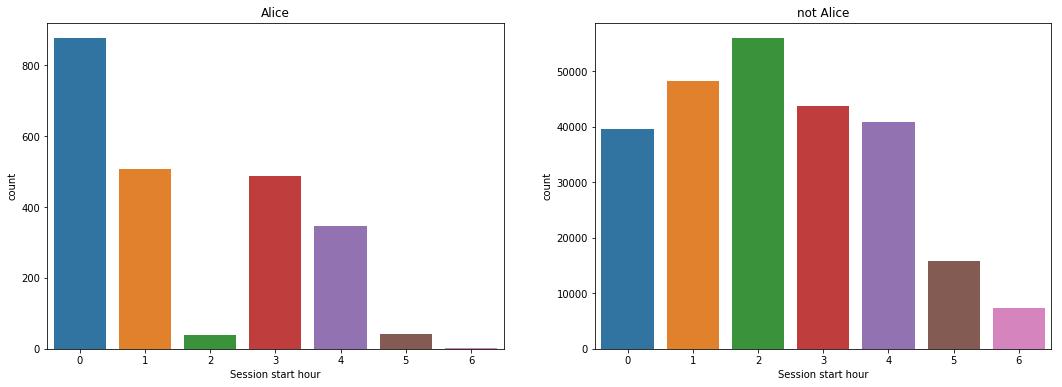

In [14]:
plt.subplots(1, 2, figsize = (18, 6)) 

plt.subplot(1, 2, 1)
sns.countplot(pd.to_datetime(train_df.time1).dt.weekday[y_train == 1])
plt.title("Alice")
plt.xlabel('Session start hour');

plt.subplot(1, 2, 2)
sns.countplot(pd.to_datetime(train_df.time1).dt.weekday[y_train == 0])
plt.title("not Alice")
plt.xlabel('Session start hour');

In [15]:
time_features['wedsday'] = (full_df.time1.dt.weekday == 2).astype('int')
time_features['weekend'] = full_df.time1.dt.weekday.isin([5,6]).astype('int')

cross = cross_val_score(logit, hstack([train_tfidf, 
                                       time_features.values[:idx_splite, :]]), 
                        y_train, cv = time_splite, scoring='roc_auc', n_jobs=4)

compare(cross, 'n_3')
res['n_4'] = {'scores' : cross, 'mean' : cross.mean(), 'sd' : cross.std(), 'comment' : 'добавил среду и выходной'}

сравнение батчей 
         n_3       new  compare
0  0.890139  0.914151     True
1  0.850524  0.901982     True
2  0.962345  0.904036    False
3  0.945684  0.958912     True
4  0.936357  0.946936     True
5  0.959617  0.976617     True
6  0.945409  0.947991     True
7  0.947709  0.961701     True
8  0.960678  0.806611    False
9  0.961918  0.968647     True

Средние:
 Новое: 0.92876 	Старое:  0.93604

SD:
 Новое: 0.048 	Старое:  0.03502


In [16]:
time_features['unknown_site'] = full_df[sites].apply(lambda x: 1 if (x == 0).sum() == 0 else 1, axis = 1)

cross = cross_val_score(logit, hstack([train_tfidf, 
                                       time_features.values[:idx_splite, :]]), 
                        y_train, cv = time_splite, scoring='roc_auc', n_jobs=4)

compare(cross, 'n_4')

сравнение батчей 
         n_4       new  compare
0  0.914151  0.914096    False
1  0.901982  0.901923    False
2  0.904036  0.903533    False
3  0.958912  0.958949     True
4  0.946936  0.946933    False
5  0.976617  0.976607    False
6  0.947991  0.948026     True
7  0.961701  0.961699    False
8  0.806611  0.806916     True
9  0.968647  0.968648     True

Средние:
 Новое: 0.92873 	Старое:  0.92876

SD:
 Новое: 0.04795 	Старое:  0.048


In [40]:
alise_site = pd.Series(train_df.loc[y_train == 1, sites].fillna(0).values.flatten()).value_counts()
not_alise_site = pd.Series(train_df.loc[y_train == 0, sites].fillna(0).values.flatten()).value_counts()

print('Топ сайты для Алисы',
     set(alise_site.index[:15].values.tolist()) - set(not_alise_site.index[:15].values.tolist()))

print('Топ сайты для не Алисы', 
      set(not_alise_site.index[:15].values.tolist()) - set(alise_site.index[:15].values.tolist()))

Топ сайты для Алисы {'static.ak.facebook.com', 'i1.ytimg.com', 's.ytimg.com', 'r3---sn-gxo5uxg-jqbe.googlevideo.com', 'r4---sn-gxo5uxg-jqbe.googlevideo.com', 'youtube.com', 'twitter.com', 's-static.ak.facebook.com', 'r1---sn-gxo5uxg-jqbe.googlevideo.com', 'r2---sn-gxo5uxg-jqbe.googlevideo.com'}
Топ сайты для не Алисы {'blast.ncbi.nlm.nih.gov', 'bing.com', 'mail.google.com', 'accounts.google.com', 'safebrowsing-cache.google.com', 'clients1.google.com', 'plus.google.com', 'annotathon.org', 'ncbi.nlm.nih.gov', 'unknown'}


In [41]:
top_alise = ['static.ak.facebook.com', 'i1.ytimg.com', 's.ytimg.com', 'r3---sn-gxo5uxg-jqbe.googlevideo.com', 
             'r4---sn-gxo5uxg-jqbe.googlevideo.com', 'youtube.com', 'twitter.com', 
             's-static.ak.facebook.com', 'r1---sn-gxo5uxg-jqbe.googlevideo.com', 'r2---sn-gxo5uxg-jqbe.googlevideo.com']

top_not_alise = ['blast.ncbi.nlm.nih.gov', 'bing.com', 'mail.google.com', 'accounts.google.com', 'safebrowsing-cache.google.com', 
                 'clients1.google.com', 'plus.google.com', 'annotathon.org', 'ncbi.nlm.nih.gov']

In [42]:
time_features['top_alise'] = full_df[sites].apply(lambda x: x.isin(top_alise).sum(), axis = 1)
time_features['top_not_alise'] = full_df[sites].apply(lambda x: x.isin(top_not_alise).sum(), axis = 1)

cross = cross_val_score(logit, hstack([train_tfidf, 
                                       time_features.values[:idx_splite, :]]), 
                        y_train, cv = time_splite, scoring='roc_auc', n_jobs=4)

compare(cross, 'n_4')
res['n_5'] = {'scores' : cross, 'mean' : cross.mean(), 'sd' : cross.std(), 'comment' : 'добавил популярные сайты'}

сравнение батчей 
         n_4       new  compare
0  0.914151  0.920883     True
1  0.901982  0.910604     True
2  0.904036  0.908102     True
3  0.958912  0.963228     True
4  0.946936  0.948281     True
5  0.976617  0.976706     True
6  0.947991  0.954414     True
7  0.961701  0.960701    False
8  0.806611  0.833727     True
9  0.968647  0.970245     True

Средние:
 Новое: 0.93469 	Старое:  0.92876

SD:
 Новое: 0.04095 	Старое:  0.048


In [432]:
logit.fit(hstack([train_tfidf, 
                 time_features.values[:idx_splite, :]]),
         y_train)
pred = logit.predict_proba(hstack([test_tfidf, 
                                   time_features.values[idx_splite:, :]]))[:, 1]
pd.DataFrame(pred, index=np.arange(1, pred.shape[0] + 1), columns=['target']).\
        to_csv('subs/sub_8.csv', index_label="session_id")

In [20]:
sites_features = full_df[sites].applymap(lambda x: len(x.split('.')))
s_names = ['len_' + str(x) for x in sites_features.columns]
sites_features.columns = s_names
sites_features['total_len_no_unknown'] = sites_features[s_names].apply(lambda x: np.sum(x[x != 1]), axis = 1)
time_features['total_len'] = sites_features.total_len_no_unknown.apply(lambda x: 1 if x > 50 else 0)

In [71]:
train_domain = train_df[sites].applymap(lambda x: x.split('.')[-1])
test_domain = test_df[sites].applymap(lambda x: x.split('.')[-1])

cnt = CountVectorizer(ngram_range=(1,1))
train_domen_sparse = cnt.fit_transform(train_domain.apply(lambda row:' '.join([i for i in row]), axis=1).tolist())
test_domen_sparse = cnt.transform(test_domain.apply(lambda row:' '.join([i for i in row]), axis=1).tolist())

sites_train_features = pd.DataFrame(index = train_df.index)
sites_train_features['gov'] = train_domen_sparse[:, 112].toarray()
sites_train_features['cn'] = train_domen_sparse[:, 87].toarray()
sites_train_features['edu'] = train_domen_sparse[:, 98].toarray()

sites_train_features[['gov', 'cn', 'edu']] = stnd.fit_transform(sites_train_features[['gov', 'cn', 'edu']].astype('float'))

sites_test_features = pd.DataFrame(index = test_df.index)
sites_test_features['gov'] = test_domen_sparse[:, 112].toarray()
sites_test_features['cn'] = test_domen_sparse[:, 87].toarray()
sites_test_features['edu'] = test_domen_sparse[:, 98].toarray()

sites_test_features[['gov', 'cn', 'edu']] = stnd.fit_transform(sites_test_features[['gov', 'cn', 'edu']].astype('float'))

In [47]:
%%time
cross = cross_val_score(logit, hstack([train_tfidf, 
                                       time_features.values[:idx_splite, :]]), 
                        y_train, cv = time_splite, scoring='roc_auc', n_jobs=-1)

compare(cross, 'n_5')
res['n_6'] = {'scores' : cross, 'mean' : cross.mean(), 'sd' : cross.std(), 'comment' : 'домены и длины'}

In [80]:
time_features['top_scale'] = stnd.fit_transform(time_features[['top_alise']].astype('float'))
time_features['top_not_scale'] = stnd.fit_transform(time_features[['top_not_alise']].astype('float'))